<a href="https://colab.research.google.com/github/seirah-yang/BootCamp/blob/main/LSTM%EC%A3%BC%EA%B0%80%EC%98%88%EC%B8%A1_0904.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install finance-datareader


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 3.9 MB/s eta 0:00:00


In [5]:
import FinanceDataReader as fdr #주식데이터를 불러오기 위한 모듈
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# 1. 데이터 불러오기 / 삼성 데이터를 1년치 가져옴
df = fdr.DataReader('005930', start='2024-05-01', end='2025-05-01')
df = df[['Close']].dropna() #종가만 가져오기
df

,Close
Date,
2024-05-02,78000
2024-05-03,77600
2024-05-07,81300
2024-05-08,81300
2024-05-09,79700
...,...
2025-04-24,55700
2025-04-25,55700
2025-04-28,55800


In [6]:
# 2. 정규화
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)
scaled_data

array([[0.7414248 ],
       [0.73087071],
       [0.82849604],
       [0.82849604],
       [0.78627968],
       [0.77308707],
       [0.75197889],
       [0.74934037],
       [0.74670185],
       [0.72559367],
       [0.7651715 ],
       [0.75197889],
       [0.73350923],
       [0.74934037],
       [0.68601583],
       [0.72031662],
       [0.73087071],
       [0.66754617],
       [0.62269129],
       [0.62269129],
       [0.68073879],
       [0.6701847 ],
       [0.72559367],
       [0.72295515],
       [0.68073879],
       [0.66754617],
       [0.70184697],
       [0.75725594],
       [0.78364116],
       [0.74406332],
       [0.78891821],
       [0.82585752],
       [0.83641161],
       [0.79419525],
       [0.81002639],
       [0.81530343],
       [0.82849604],
       [0.83641161],
       [0.83377309],
       [0.84168865],
       [0.84168865],
       [0.84168865],
       [0.91556728],
       [0.98153034],
       [0.98944591],
       [1.        ],
       [1.        ],
       [0.994

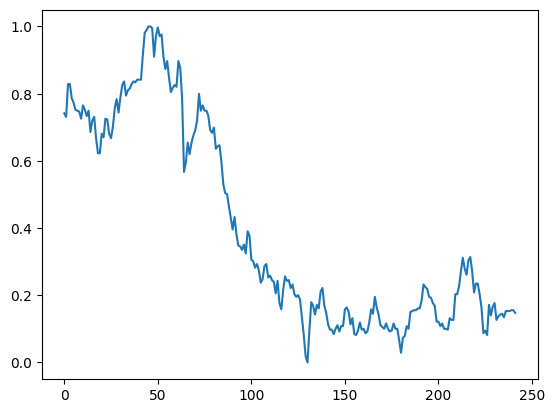

In [8]:
plt.plot(scaled_data)

# 시계열 데이터를 분석할 때 유념해야할 점
# 사계절성 - 날씨, 봄/여름/가을/겨울
# 트렌드성 - 그때 그때 다름
# 경제효과 - 코스닥, 나스닥 비교, 경제지표를 추가 하는 등의 방법을 쓰면 좋다.
# 사회적인 이슈 (ex. COVID-19)

<Axes: xlabel='Date'>

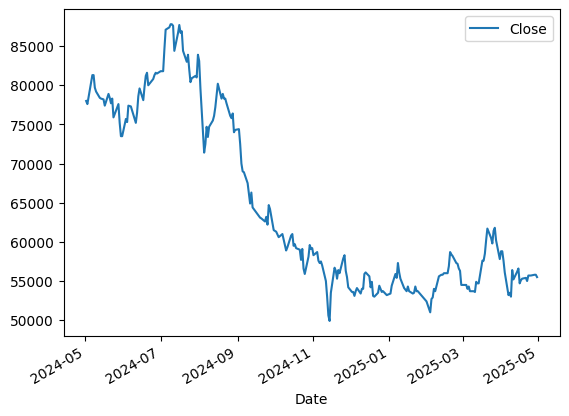

In [7]:
df.plot()

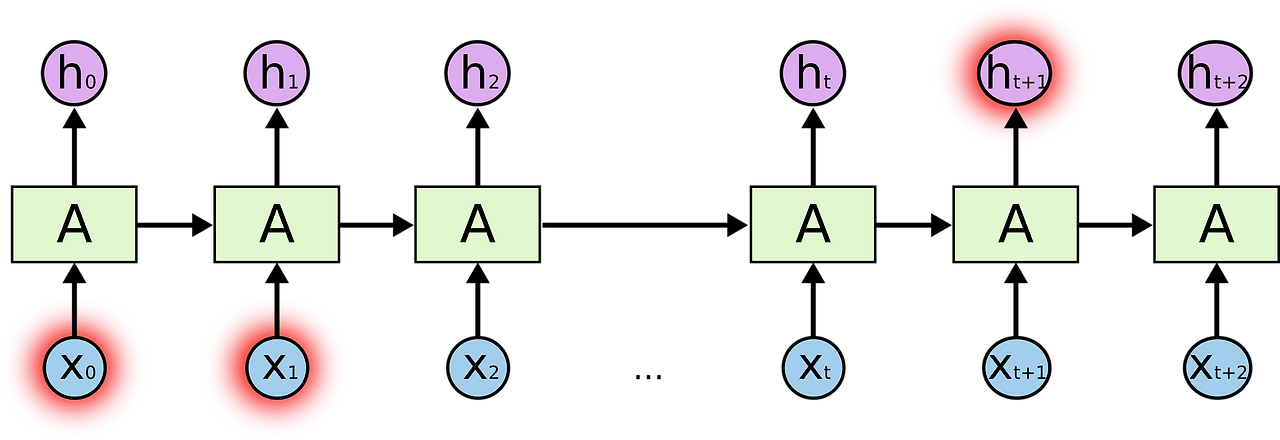

In [9]:
# 예시) shift 연산
alist = ['첫째날', '둘째날', '셋째날', '넷째날', '다섯쨰날', '여섯째날', '일곱째날']

for i in range(len(alist)):
    print(alist[i:i+2])

['첫째날', '둘째날']
['둘째날', '셋째날']
['셋째날', '넷째날']
['넷째날', '다섯쨰날']
['다섯쨰날']


In [10]:
# 예시) shift 연산
alist = ['첫째날', '둘째날', '셋째날', '넷째날', '다섯쨰날', '여섯째날', '일곱째날']

for i in range(len(alist)):
    print(alist[i:i+3])

['첫째날', '둘째날', '셋째날']
['둘째날', '셋째날', '넷째날']
['셋째날', '넷째날', '다섯쨰날']
['넷째날', '다섯쨰날', '여섯째날']
['다섯쨰날', '여섯째날', '일곱째날']
['여섯째날', '일곱째날']
['일곱째날']


In [11]:
# 예시) shift 연산
alist = ['첫째날', '둘째날', '셋째날', '넷째날', '다섯쨰날', '여섯째날', '일곱째날']

for i in range(len(alist)):
    print(alist[i:i+4])

['첫째날', '둘째날', '셋째날', '넷째날']
['둘째날', '셋째날', '넷째날', '다섯쨰날']
['셋째날', '넷째날', '다섯쨰날', '여섯째날']
['넷째날', '다섯쨰날', '여섯째날', '일곱째날']
['다섯쨰날', '여섯째날', '일곱째날']
['여섯째날', '일곱째날']
['일곱째날']


60(d) x 3 (hight, open, volume) 실제데이터-> 14(d) x 3 (hight, open, volume) 예측

In [13]:
import FinanceDataReader as fdr
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# 삼성전자 주식 1년치(2024년도 것만 본다)
df = fdr.DataReader('005930', start='2024-01-01', end='2024-12-31')
    # 오픈가, 고가, 저가, 거래량, 종가
df = df[['Open', 'High', 'Low', 'Volume', 'Close']].dropna()

        # 오픈가, 고가, 저가, 거래량
X = df[['Open', 'High', 'Low', 'Volume']].values
        # 종가예측
y = df['Close'].values

# 피쳐들과 정답값에 둘다 스케일링
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_normalized = scaler_X.fit_transform(X)
y_normalized = scaler_y.fit_transform(y.reshape(-1, 1))

# 시퀀스 생성 (60일 입력, 14일 예측)
def create_sequences(data_X, data_y, seq_len=60, pred_len=14):
    xs, ys = [], []
    for i in range(len(data_X) - seq_len - pred_len):
        #피쳐에서 i번째 ~ i+60일치 슬라이싱 = 0번쨰일 ~ 59번째일
        xs.append(data_X[i:i+seq_len])
                                    # 59     :        59 + 14
        ys.append(data_y[i+seq_len:i+seq_len+pred_len].flatten())
    return np.array(xs), np.array(ys)
                                                        #피쳐                #정답값(종가)
X_seq, y_seq = create_sequences(X_normalized, y_normalized, 60, 14)

In [14]:
print(len(X_seq)) #170개의 데이터 뽑음 125:45
print(len(X_seq[0])) #60일치
print(len(X_seq[0][0])) #4개 피쳐 open, high, low, volume


170
60
4


In [21]:
# 텐서로 변환
X_seq = torch.FloatTensor(X_seq)
y_seq = torch.FloatTensor(y_seq)

split = int(len(X_seq) * 0.8)
train_X, test_X = X_seq[:split], X_seq[split:]
train_y, test_y = y_seq[:split], y_seq[split:]
print(len(train_X), len(test_X ))

136 34


In [16]:
train_X.shape

torch.Size([136, 60, 4])

In [26]:
train_dataset = TensorDataset(train_X, train_y)
test_dataset = TensorDataset(test_X, test_y)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

one_X, one_y= next(iter(train_loader))
print(len(one_X))                  # 32 batch
print(len(one_X[0]))             # 60days
print(len(one_X[0][0]))        # 4chanel      =>(32,60,4)

32
60
4


In [27]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # 마지막 타임스텝만 사용
        return out


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTMModel(input_size=4, hidden_size=64, num_layers=2, output_size=14).to(device)
            # inputsize, output size는 꼭 지정해줍시다.
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)


for epoch in range(50):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        # print(outputs.shape)
        # break

        loss = criterion(outputs, y_batch)

        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")



Epoch 1, Loss: 0.4527
Epoch 2, Loss: 0.4264
Epoch 3, Loss: 0.4092
Epoch 4, Loss: 0.3333
Epoch 5, Loss: 0.2584
Epoch 6, Loss: 0.1358
Epoch 7, Loss: 0.0733
Epoch 8, Loss: 0.0627
Epoch 9, Loss: 0.0411
Epoch 10, Loss: 0.0438
Epoch 11, Loss: 0.0444
Epoch 12, Loss: 0.0431
Epoch 13, Loss: 0.0362
Epoch 14, Loss: 0.0370
Epoch 15, Loss: 0.0343
Epoch 16, Loss: 0.0295
Epoch 17, Loss: 0.0331
Epoch 18, Loss: 0.0292
Epoch 19, Loss: 0.0288
Epoch 20, Loss: 0.0251
Epoch 21, Loss: 0.0252
Epoch 22, Loss: 0.0230
Epoch 23, Loss: 0.0219
Epoch 24, Loss: 0.0211
Epoch 25, Loss: 0.0216
Epoch 26, Loss: 0.0215
Epoch 27, Loss: 0.0212
Epoch 28, Loss: 0.0205
Epoch 29, Loss: 0.0207
Epoch 30, Loss: 0.0202
Epoch 31, Loss: 0.0205
Epoch 32, Loss: 0.0180
Epoch 33, Loss: 0.0183
Epoch 34, Loss: 0.0180
Epoch 35, Loss: 0.0183
Epoch 36, Loss: 0.0187
Epoch 37, Loss: 0.0191
Epoch 38, Loss: 0.0178
Epoch 39, Loss: 0.0205
Epoch 40, Loss: 0.0201
Epoch 41, Loss: 0.0196
Epoch 42, Loss: 0.0163
Epoch 43, Loss: 0.0177
Epoch 44, Loss: 0.01

위에서 scaling 해줬다 그러면 inverse scaling 해줘야 한다.

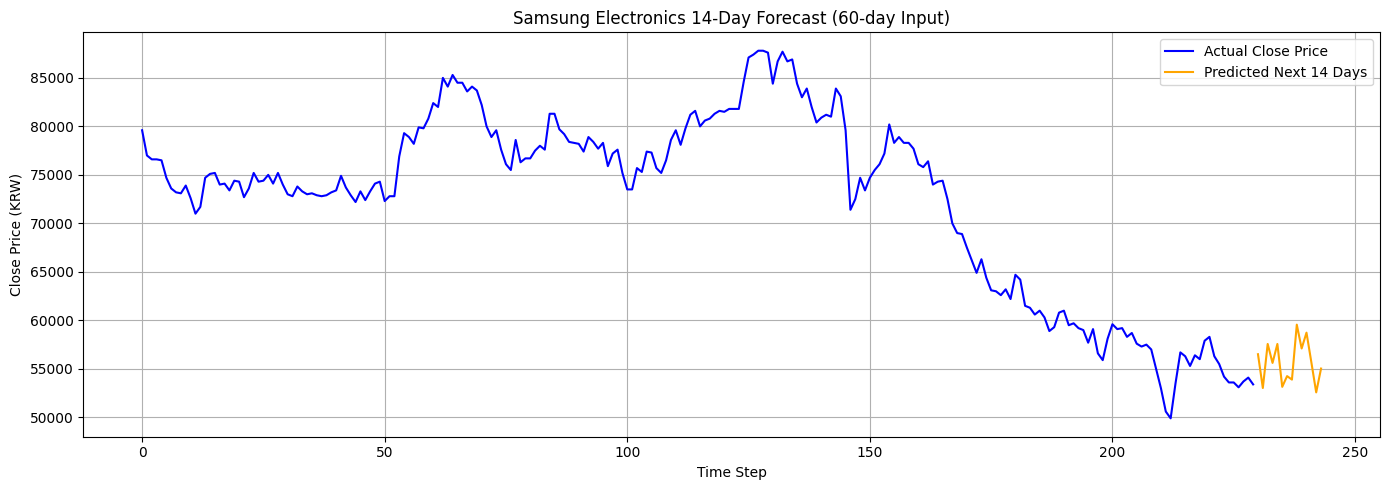

In [28]:
# 예측 및 시각화
model.eval()
with torch.no_grad():
    pred = model(test_X.to(device)).cpu().numpy()
    actual = test_y.cpu().numpy()

# 역정규화
pred = scaler_y.inverse_transform(pred)
actual = scaler_y.inverse_transform(actual)

# 마지막 예측 결과 시각화
plt.figure(figsize=(14, 5))
plt.plot(range(len(y) - 14), y[:-14], label='Actual Close Price', color='blue')

plt.plot(range(len(y)-14, len(y)), pred[-1], label='Predicted Next 14 Days', color='orange')
plt.title('Samsung Electronics 14-Day Forecast (60-day Input)')
plt.xlabel('Time Step')
plt.ylabel('Close Price (KRW)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


In [29]:
# 모델 저장
torch.save(model.state_dict(), "lstm_stock_forecast.pt")
